##**Instaladores**

In [ ]:
!pip install pandas scikit-learn matplotlib seaborn >nul 2>&1
!pip install catboost >nul 2>&1

In [ ]:
!pip install optuna >nul 2>&1

##**Librerias**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import optuna

drive.mount('/content/drive')
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Funciones**

In [ ]:
#Tabla resumen
def resumen(dataframe):
  # Cálculos de resumen
  null_counts = dataframe.isnull().sum()
  total_counts = len(dataframe)
  non_null_counts = dataframe.notnull().sum()
  data_types = dataframe.dtypes
  unique_counts = dataframe.nunique()
  # Crear DataFrame de resumen
  summary_df = pd.DataFrame({
      'Tipo de Dato': data_types,
      'Valores Únicos': unique_counts,
      'No Nulos': non_null_counts,
      'Nulos': null_counts,
      '% Nulos': (null_counts / total_counts) * 100
  })
  # Ordenar por % de nulos
  summary_df = summary_df.sort_values(by='% Nulos', ascending=False)
  # Aplicar formato con Styler
  styled_summary = summary_df.style \
      .format({'% Nulos': '{:.2f}%'}) \
      .bar(subset='% Nulos', color='#f08080') \
      .set_properties(**{'text-align': 'center'}) \
      .set_caption("Resumen de Columnas del DataFrame") \
      .set_table_styles([
          # Color del encabezado de columnas
          {'selector': 'th', 'props': [
              ('text-align', 'center'),
              ('background-color', '#1f4e79'),
              ('color', 'white'),
              ('font-weight', 'bold')
          ]},
          # Color de las celdas
          {'selector': 'td', 'props': [('padding', '5px')]},
          # Estilo del título de la tabla
          {'selector': 'caption', 'props': [
              ('color', '#1f4e79'),
              ('font-size', '18px'),
              ('text-align', 'center'),
              ('font-weight', 'bold')
          ]}
      ])
  # Mostrar
  display(styled_summary)
  # Información final
  print(f"\n🧾 El DataFrame tiene un total de **{len(dataframe.columns)}** columnas y **{len(dataframe)}** filas.")

In [ ]:
#Función Encabezado
def encabezado(dataframe,filas=5):
  salida=dataframe.head(filas).style \
      .set_properties(**{
          'background-color': '#f9f9f9',
          'border': '1px solid #ddd',
          'text-align': 'center'
      }) \
      .set_table_styles([
          {'selector': 'th', 'props': [('background-color', '#4B8BBE'), ('color', 'white'), ('text-align', 'center')]}
      ]) \
      .highlight_null() \
      .set_caption("🔍 Vista Previa de los Primeros Registros")
  display(salida)

##**Cargar Datos**

In [ ]:
X_train = pd.read_csv('/content/drive/MyDrive/X_train.csv')
Y_train = pd.read_csv('/content/drive/MyDrive/y_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/X_test.csv')
id_test = pd.read_csv('/content/drive/MyDrive/id_test.csv')

In [ ]:
resumen(X_train)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Tipo de Dato,Valores Únicos,No Nulos,Nulos,% Nulos
ESTU_PRGM_DEPARTAMENTO,float64,688698,692500,0,0.00%
ESTU_VALORMATRICULAUNIVERSIDAD,float64,692310,692500,0,0.00%
ESTU_HORASSEMANATRABAJA,float64,692436,692500,0,0.00%
FAMI_ESTRATOVIVIENDA,float64,692422,692500,0,0.00%
FAMI_TIENEINTERNET,int64,2,692500,0,0.00%
FAMI_EDUCACIONPADRE,float64,692050,692500,0,0.00%
FAMI_TIENELAVADORA,int64,2,692500,0,0.00%
FAMI_TIENEAUTOMOVIL,int64,2,692500,0,0.00%
ESTU_PAGOMATRICULAPROPIO,int64,2,692500,0,0.00%
FAMI_TIENECOMPUTADOR,int64,2,692500,0,0.00%



🧾 El DataFrame tiene un total de **25** columnas y **692500** filas.


In [ ]:
encabezado(X_train)

,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,coef_1,coef_2,coef_3,coef_4,EDUMADRE_DISCRIMINANTE,EDUPADRE_DISCRIMINANTE,GRUPO_DEPARTAMENTO,ISE,ESFUERZO_FAMILIAR,ACCESO_TECNOLOGICO,NIVEL_SOCIOFAMILIAR,DESAJUSTE_ECONOMICO,INCONGRUENCIA_ISE_MATRICULA,ESFUERZO_NORM
0,1.491769,1.491769,1.491769,1.491769,1,1.491769,1,1,0,1,1.491769,0.437002,-0.556223,0.813978,0.060296,1.491769,1.491769,1.491769,1.395273,0.320585,0.415248,1.130560,1.137621,-1.202997,-0.652458
1,1.491769,1.491769,1.491769,1.745884,0,1.491769,1,0,0,1,1.491769,0.346934,-0.481341,0.508180,0.016142,1.491769,1.491769,1.491769,0.380067,-1.022363,-0.761210,0.418709,-0.004977,-0.361375,-0.936679
2,1.745884,1.245884,1.491769,1.497256,1,1.491769,1,0,0,0,1.491769,0.232301,-0.492038,0.729034,0.016142,1.491769,1.245884,1.745884,-0.055021,0.768234,-1.937669,-0.115179,-0.004977,0.143598,0.275999
3,1.491769,1.491769,1.245884,1.491769,1,1.491769,1,0,0,1,1.245884,1.583325,-0.941332,-0.171371,-0.690324,1.245884,1.745884,1.497256,-0.345080,-0.574714,0.415248,-0.649068,-0.004977,0.648571,-0.354025
4,1.491769,1.163923,1.491769,1.372942,1,1.491769,1,1,0,1,1.491769,0.387874,-0.299484,0.389259,0.457683,1.491769,1.491769,1.122942,-0.345080,0.320585,0.415248,-0.649068,-0.004977,0.480247,0.242839


In [ ]:
resumen(X_test)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Tipo de Dato,Valores Únicos,No Nulos,Nulos,% Nulos
ESTU_PRGM_DEPARTAMENTO,float64,31,296786,0,0.00%
ESTU_VALORMATRICULAUNIVERSIDAD,float64,8,296786,0,0.00%
ESTU_HORASSEMANATRABAJA,float64,5,296786,0,0.00%
FAMI_ESTRATOVIVIENDA,float64,7,296786,0,0.00%
FAMI_TIENEINTERNET,int64,2,296786,0,0.00%
FAMI_EDUCACIONPADRE,float64,12,296786,0,0.00%
FAMI_TIENELAVADORA,int64,2,296786,0,0.00%
FAMI_TIENEAUTOMOVIL,int64,2,296786,0,0.00%
ESTU_PAGOMATRICULAPROPIO,int64,2,296786,0,0.00%
FAMI_TIENECOMPUTADOR,int64,2,296786,0,0.00%



🧾 El DataFrame tiene un total de **25** columnas y **296786** filas.


In [ ]:
encabezado(X_test)

,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PAGOMATRICULAPROPIO,FAMI_TIENECOMPUTADOR,FAMI_EDUCACIONMADRE,coef_1,coef_2,coef_3,coef_4,EDUMADRE_DISCRIMINANTE,EDUPADRE_DISCRIMINANTE,GRUPO_DEPARTAMENTO,ACCESO_TECNOLOGICO,ESFUERZO_FAMILIAR,ISE,NIVEL_SOCIOFAMILIAR,DESAJUSTE_ECONOMICO,INCONGRUENCIA_ISE_MATRICULA,ESFUERZO_NORM
0,1.576757,1.391822,1.396823,1.482493,1,1.453422,1,0,1,1,1.674290,0.492496,-0.433304,0.907947,-0.228590,1.674290,1.517896,1.579579,0.366753,-1.463543,-0.384764,0.022671,-1.535605,0.014923,-0.961952
1,1.407371,1.678276,1.547282,1.609556,1,1.548989,1,0,0,1,1.451805,-0.339797,0.243260,0.555805,0.910679,1.524045,1.517896,1.436167,0.366753,0.319710,0.203780,0.202456,0.622868,-0.156366,-0.137839
2,1.458951,1.684564,1.243946,1.482493,1,1.609116,1,0,0,1,1.568799,0.138153,-0.338162,0.522267,-0.228590,1.524045,1.519429,1.436167,0.366753,-1.463543,-0.237628,-0.157114,-0.456368,0.186211,-1.017887
3,1.716829,1.684564,1.547282,1.657122,0,1.688850,1,0,0,0,1.696341,-0.891912,1.564675,-0.735383,0.466808,1.687228,1.682998,1.579579,-3.721459,-0.126103,-1.561853,-1.775180,0.622868,1.727805,1.890747
4,1.481302,1.678276,1.491930,1.609556,1,1.548989,1,0,0,1,1.568799,-0.488126,0.243260,0.723491,0.348442,1.524045,1.517896,1.579579,0.366753,-0.126103,-0.090492,-0.157114,0.622868,0.186211,-0.222363


In [ ]:
encabezado(Y_train)

,RENDIMIENTO_GLOBAL
0,medio-alto
1,bajo
2,bajo
3,alto
4,medio-bajo


In [ ]:
#Codificacion Ordinal, Importante para el modelo
ordinal_Y={
    'alto':3,
    'medio-alto':2,
    'medio-bajo':1,
    'bajo':0
}
Y_train['RENDIMIENTO_GLOBAL']=Y_train['RENDIMIENTO_GLOBAL'].map(ordinal_Y)

In [ ]:
encabezado(Y_train)

,RENDIMIENTO_GLOBAL
0,2
1,0
2,0
3,3
4,1


##**Modelos**

📋 Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.42      0.54      0.47     34597
           1       0.32      0.25      0.28     34455
           2       0.32      0.24      0.27     34324
           3       0.51      0.61      0.56     35124

    accuracy                           0.41    138500
   macro avg       0.39      0.41      0.40    138500
weighted avg       0.39      0.41      0.40    138500



/tmp/ipython-input-16-3025508817.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


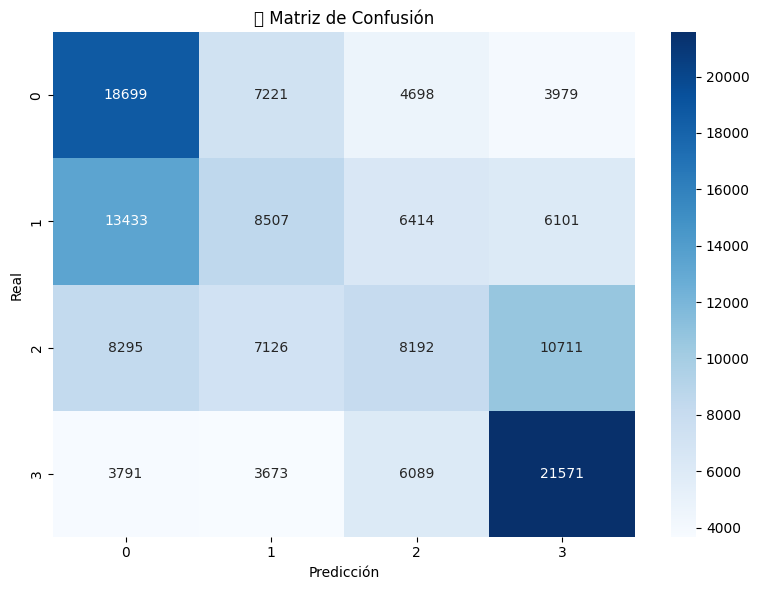

/tmp/ipython-input-16-3025508817.py:58: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


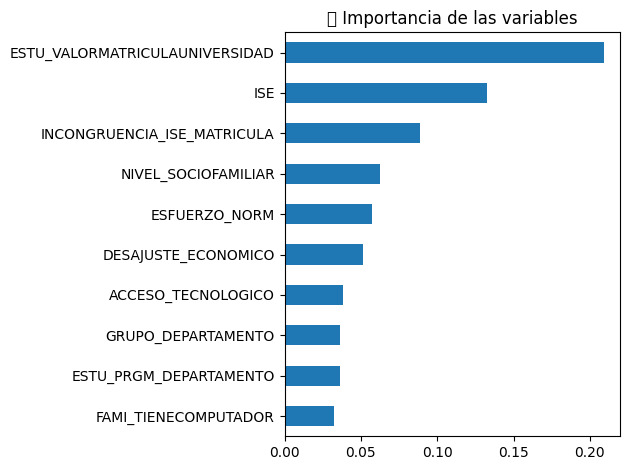

In [ ]:
# Asegura que Y_train sea una Serie
Y_train = Y_train.squeeze()

# ============================
# División de datos entrenamiento / validación
# ============================
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=42
)

# ============================
# Modelo Random Forest
# ============================
rf_model = RandomForestClassifier(
    n_estimators=100,         # número de árboles
    max_depth=10,             # profundidad máxima (ajustable)
    min_samples_leaf=5,       # hojas mínimas (ajustable)
    random_state=42,
    n_jobs=-1                 # para usar todos los núcleos disponibles
)
rf_model.fit(X_train_final, y_train_final)

# ============================
# Predicción y evaluación
# ============================
y_pred = rf_model.predict(X_val_final)

print("📋 Reporte de Clasificación:\n")
print(classification_report(y_val_final, y_pred))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(Y_train),
            yticklabels=np.unique(Y_train))
plt.title('📊 Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# ============================
# Importancia de variables (opcional)
# ============================
importancias = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importancias.nlargest(10).plot(kind='barh')
plt.title("🌲 Importancia de las variables")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Asegura que Y_train sea Serie
Y_train = Y_train.squeeze()

# ============================
# 1. Revisar distribución de clases
# ============================
print("📊 Distribución de clases:")
print(Y_train.value_counts(normalize=True), "\n")

# ============================
# 2. Eliminar variables de muy baja importancia con modelo inicial rápido
# ============================
modelo_preliminar = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
modelo_preliminar.fit(X_train, Y_train)

importancias = pd.Series(modelo_preliminar.feature_importances_, index=X_train.columns)
variables_bajas = importancias[importancias < 0.001].index.tolist()
print(f"🧹 Eliminando {len(variables_bajas)} variables con baja importancia (<0.001)\n")

X_train_filtrado = X_train.drop(columns=variables_bajas)

# ============================
# 3. División de datos
# ============================
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_filtrado, Y_train, stratify=Y_train, test_size=0.2, random_state=42
)

# ============================
# 4. Modelo Random Forest mejorado
# ============================
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_final, y_train_final)

# ============================
# 5. Validación cruzada
# ============================
scores = cross_val_score(rf_model, X_train_filtrado, Y_train, cv=5, scoring='accuracy')
print(f"🔁 Accuracy promedio validación cruzada (5-fold): {scores.mean():.4f}\n")

# ============================
# 6. Evaluación final
# ============================
y_pred = rf_model.predict(X_val_final)

print("📋 Reporte de Clasificación:\n")
print(classification_report(y_val_final, y_pred, digits=4))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_final, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(Y_train),
            yticklabels=np.unique(Y_train))
plt.title('📊 Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# ============================
# 7. Importancia de variables (top 10)
# ============================
importancias_final = pd.Series(rf_model.feature_importances_, index=X_train_final.columns)
importancias_final.nlargest(10).plot(kind='barh')
plt.title("🌲 Top 10 Importancia de las variables")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


📊 Distribución de clases:
RENDIMIENTO_GLOBAL
3    0.253601
0    0.249801
1    0.248773
2    0.247825
Name: proportion, dtype: float64 

🧹 Eliminando 0 variables con baja importancia (<0.001)

